In [1]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Set memory growth to True to allocate memory as needed
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set a memory limit of 10GB (10240MB)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=11264)])
    except RuntimeError as e:
        print(e)


In [2]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# List all physical devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if TensorFlow is using the GPU
if gpus:
    print("Number of GPUs available: ", len(gpus))
    for gpu in gpus:
        print("GPU:", gpu)

    # Perform a simple computation on the GPU
    with tf.device('/GPU:0'):
        a = tf.constant(2.0)
        b = tf.constant(3.0)
        c = a * b
        print(f"Result of computation on GPU: {c.numpy()}")
else:
    print("No GPU found")


TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs available:  1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result of computation on GPU: 6.0


# Get the required data

In [3]:
train_dir = "D:\\Wikiart_splitted\\train"
test_dir = "D:\\Wikiart_splitted\\test"
val_dir= "D:\\Wikiart_splitted\\val"

# Import necessary libraries and modules

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [5]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Prepare the data

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 299  # Adjusted for Xception
img_width = 299

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=random_seed
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure consistent order
)

# Define number of classes
num_classes = train_generator.num_classes


Found 60768 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.
Found 7596 images belonging to 19 classes.


# Build the Model

In [7]:
from tensorflow.keras.layers import UpSampling2D, Concatenate, Conv2D, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import tensorflow.keras.backend as K

def pyramid_feature_fusion(layers, num_filters=64):
    layers = layers[::-1]
    fused_layer = layers[0]
    
    for i in range(1, len(layers)):
        target_shape = tf.shape(layers[i])[1:3]
        resized_layer = tf.image.resize(fused_layer, target_shape, method='nearest')
        resized_layer = Conv2D(num_filters, kernel_size=1, padding='same')(resized_layer)
        fused_layer = Concatenate()([resized_layer, Conv2D(num_filters, kernel_size=1, padding='same')(layers[i])])
    
    return Conv2D(num_filters, kernel_size=3, padding='same')(fused_layer)

# Define image dimensions
img_height, img_width = 299, 299

# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Extract feature maps from different stages of the base model
layer_names = ['block13_pool', 'block12_sepconv2_bn', 'block4_sepconv2_bn']
layers = [base_model.get_layer(name).output for name in layer_names]

# Apply pyramid feature fusion
fused_layer = pyramid_feature_fusion(layers, num_filters=128)

# Global average pooling
x = GlobalAveragePooling2D()(fused_layer)

# Add custom layers on top of the fused feature map
x = Dense(256, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Define number of classes based on the training generator
num_classes = train_generator.num_classes

# Add the final output layer with the correct number of classes
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the complete model
model.summary()

# Print the number of trainable parameters
trainable_count = int(np.sum([K.count_params(w) for w in model.trainable_weights]))
print(f'Trainable parameters: {trainable_count}')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

# Train the model

In [8]:
# Define callbacks
checkpoint = ModelCheckpoint('pyramid2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1899/1899 [==============================] - ETA: 0s - loss: 3.6762 - accuracy: 0.3572
Epoch 1: val_accuracy improved from -inf to 0.49393, saving model to pyramid2.h5
1899/1899 [==============================] - 1335s 701ms/step - loss: 3.6762 - accuracy: 0.3572 - val_loss: 2.7755 - val_accuracy: 0.4939
Epoch 2/10
1899/1899 [==============================] - ETA: 0s - loss: 2.6504 - accuracy: 0.4495
Epoch 2: val_accuracy improved from 0.49393 to 0.51094, saving model to pyramid2.h5
1899/1899 [==============================] - 1311s 690ms/step - loss: 2.6504 - accuracy: 0.4495 - val_loss: 2.2334 - val_accuracy: 0.5109
Epoch 3/10
1899/1899 [==============================] - ETA: 0s - loss: 2.1687 - accuracy: 0.4813
Epoch 3: val_accuracy improved from 0.51094 to 0.51951, saving model to pyramid2.h5
1899/1899 [==============================] - 1329s 700ms/step - loss: 2.1687 - accuracy: 0.4813 - val_loss: 1.9065 - val_accuracy: 0.5195
Epoch 4/10
1899/1899 [=====================

In [9]:
model.save('py2.h5')

# Evaluate the model

In [10]:
model.load_weights('pyramid2.h5')
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')


237/237 [==============================] - 160s 673ms/step - loss: 1.4659 - accuracy: 0.5446
Test accuracy: 0.5445675253868103


# Plot train and validation accuracy and loss graphs

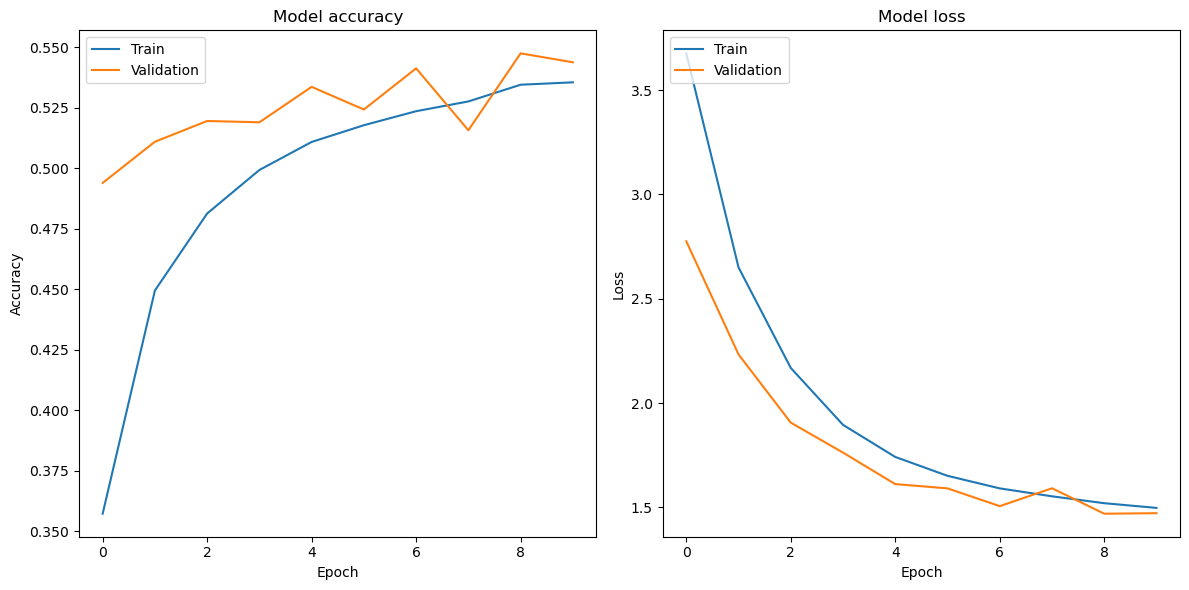

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Plot confusion matrix and classification metrics

238/238 [==============================] - 158s 663ms/step


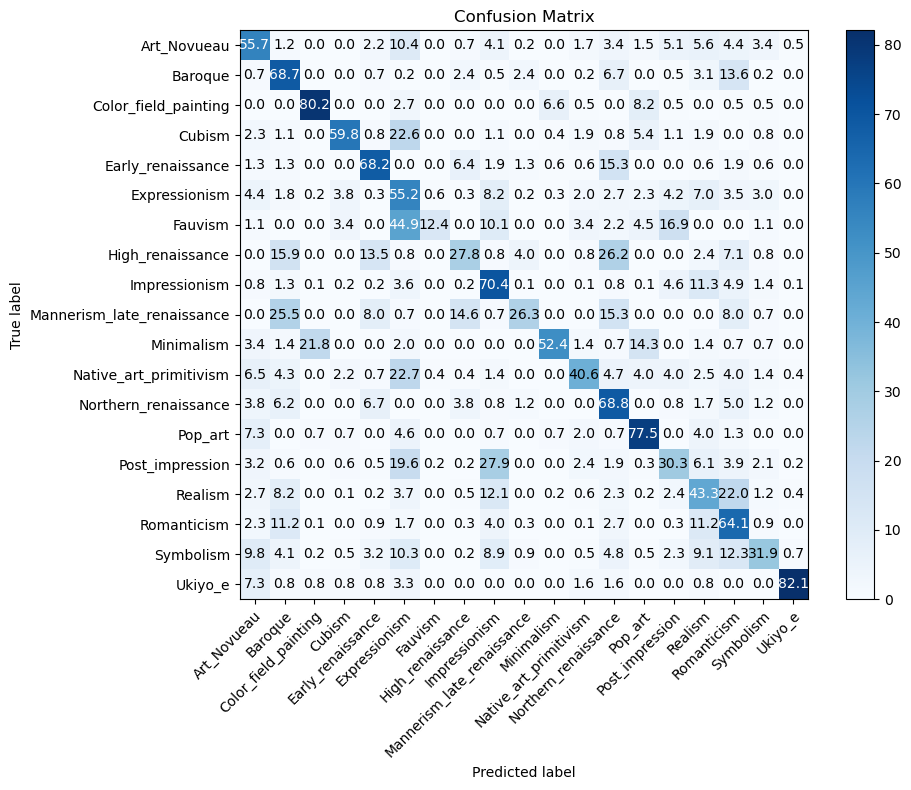

                            precision    recall  f1-score   support

               Art_Novueau       0.52      0.56      0.54       413
                   Baroque       0.48      0.69      0.56       418
      Color_field_painting       0.79      0.80      0.80       182
                    Cubism       0.77      0.60      0.67       261
         Early_renaissance       0.54      0.68      0.60       157
             Expressionism       0.42      0.55      0.48       659
                   Fauvism       0.65      0.12      0.21        89
          High_renaissance       0.34      0.28      0.31       126
             Impressionism       0.66      0.70      0.68      1314
Mannerism_late_renaissance       0.55      0.26      0.36       137
                Minimalism       0.80      0.52      0.63       147
    Native_art_primitivism       0.63      0.41      0.50       278
      Northern_renaissance       0.40      0.69      0.51       240
                   Pop_art       0.56      0.77

In [16]:
class_names = list(train_generator.class_indices.keys())

# Reset the test generator and make predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f'  # Format as percentage with one decimal place
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot normalized confusion matrix
plot_confusion_matrix(cm_percentage, class_names)
plt.show()

# Print classification report for further evaluation
print(classification_report(y_true, y_pred, target_names=class_names))
